Matching results saved to ../data_processed/matchingResults.csv


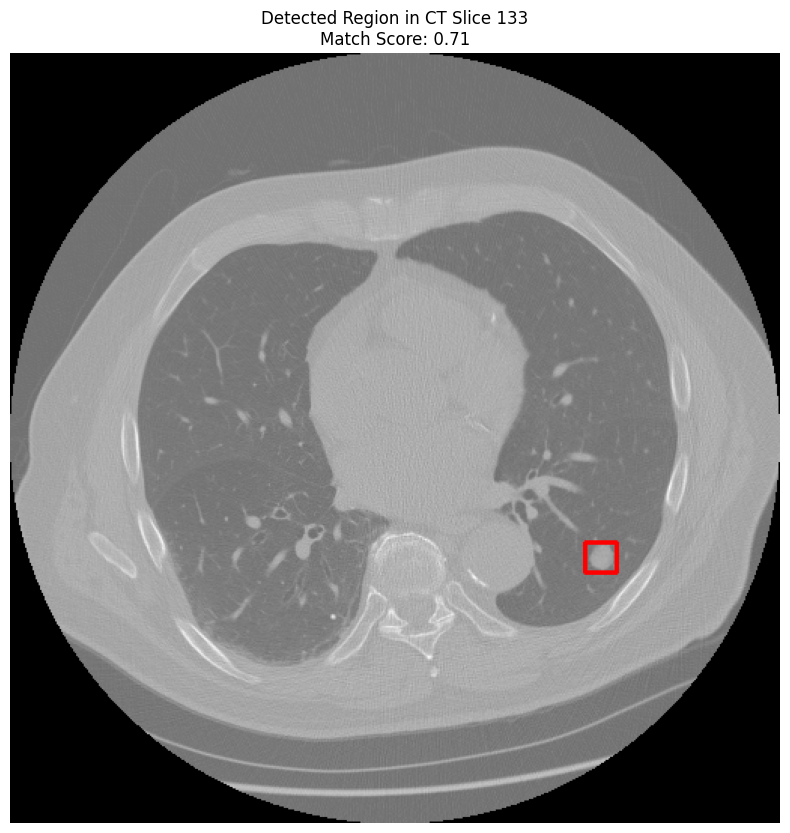

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path   = "../test_processed/3246/3246_full_volume.npy"
templates_path = "../data_processed/templates.npy"  # file containing a list of templates
results_csv    = "../data_processed/matchingResults.csv"

# -----------------------
# Load the CT volume and the templates
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan volume (assumed shape: [n_slices, height, width])
templates_list = np.load(templates_path, allow_pickle=True)
n_slices = ct_volume.shape[0]

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum 70% match threshold
tol             = 5    # tolerance in pixels for grouping adjacent hits

# List to hold final results.
# Each result is a dict: template_uuid, mask_file info, CT slice index, top-left coordinate, and match score.
results = []

# -----------------------
# Iterate over each template in the list
# -----------------------
for template_dict in templates_list:
    # Extract the template image and associated metadata.
    template = template_dict["template"]
    uuid     = template_dict["uuid"]
    mask_file = template_dict["mask_file"]
    
    # Ensure the template is in float32 and scale if necessary.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape

    # -----------------------
    # Perform template matching for the current template over all CT slices.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        
        # Normalize CT slice to 0-255 for consistency.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Apply template matching.
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        # Record the hit if the match score meets/exceeds the threshold.
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits (across adjacent slices) by their location.
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # use the first hit's location as a representative.
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, select the "middle" slice as the hit location and record the result.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        
        results.append({
            "template_uuid": uuid,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "top_left": str(sel_top_left),
            "match_score": sel_score
        })

# -----------------------
# Check if any template matches were found.
# -----------------------
if not results:
    raise ValueError("No template matches found above the threshold.")

# -----------------------
# Save the results to a CSV file.
# -----------------------
df = pd.DataFrame(results)
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# Optionally, if you want to also display one of the detected regions:
# (For demonstration, we'll show the first result.)
first_result = results[0]
template_uuid = first_result["template_uuid"]
sel_slice_idx = first_result["CT_slice"]
sel_top_left = eval(first_result["top_left"])  # convert string back to tuple
# Find the corresponding template in the templates_list.
template_info = next(item for item in templates_list if item["uuid"] == template_uuid)
template = template_info["template"]
if template.dtype != np.float32:
    template = template.astype(np.float32)
if template.max() <= 1:
    template = (template * 255).astype(np.float32)
h, w = template.shape

# Load and normalize the selected CT slice.
selected_slice = np.squeeze(ct_volume[sel_slice_idx])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)

# Convert to color for overlay.
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)
bottom_right = (sel_top_left[0] + w, sel_top_left[1] + h)
# Draw a red rectangle around the detected match.
cv2.rectangle(ct_color, sel_top_left, bottom_right, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Region in CT Slice {sel_slice_idx}\nMatch Score: {first_result['match_score']:.2f}")
plt.axis("off")
plt.show()


Matching results saved to ../data_processed/matchingResults.csv
Most recurring CT slice: 130


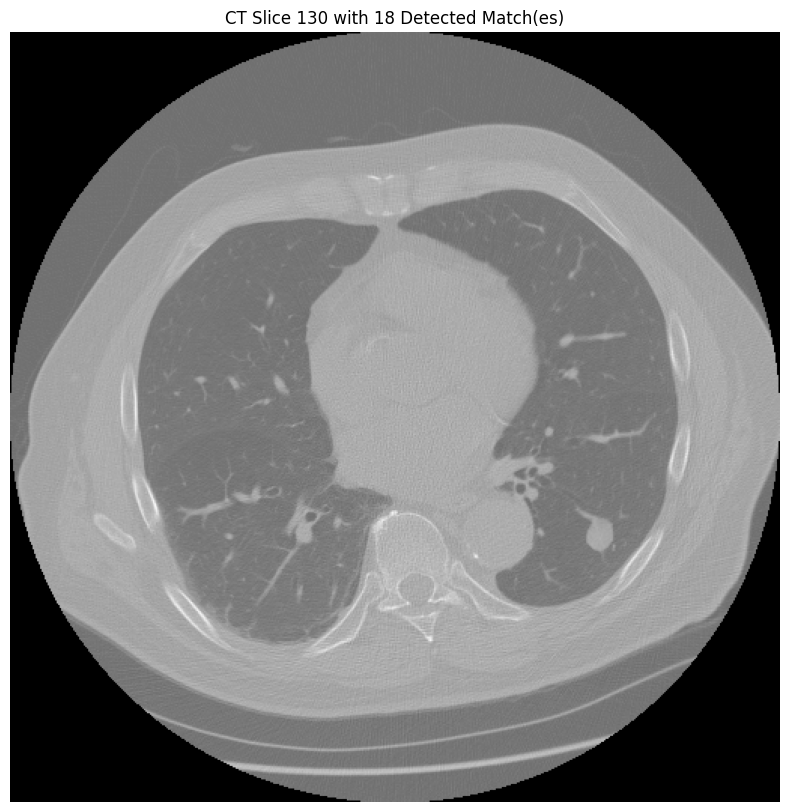

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path   = "../test_processed/3246/3246_full_volume.npy"
templates_path = "../data_processed/templates.npy"  # file containing a list of templates
results_csv    = "../data_processed/matchingResults.csv"

# -----------------------
# Load the CT volume and the templates
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan volume (assumed shape: [n_slices, height, width])
templates_list = np.load(templates_path, allow_pickle=True)
n_slices = ct_volume.shape[0]

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum 70% match threshold
tol             = 5    # tolerance in pixels for grouping adjacent hits

# List to hold final results.
results = []

# -----------------------
# Iterate over each template in the list and perform matching.
# -----------------------
for template_dict in templates_list:
    # Extract the template image and associated metadata.
    template = template_dict["template"]
    uuid     = template_dict["uuid"]
    mask_file = template_dict["mask_file"]
    
    # Ensure the template is in float32 and scale if necessary.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape

    # -----------------------
    # Perform template matching for the current template over all CT slices.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        
        # Normalize CT slice to 0-255.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Apply template matching.
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        # Record the hit if the match score meets/exceeds the threshold.
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits (across adjacent slices) by their location.
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative location from first hit in the cluster
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, select the "middle" slice as the hit location and record the result.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        
        results.append({
            "template_uuid": uuid,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "top_left": str(sel_top_left),  # stored as string, later convert with eval
            "match_score": sel_score
        })

# -----------------------
# Check if any template matches were found.
# -----------------------
if not results:
    raise ValueError("No template matches found above the threshold.")

# -----------------------
# Save the results to a CSV file.
# -----------------------
df = pd.DataFrame(results)
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# -----------------------
# Determine the most recurring CT slice from the results.
# -----------------------
df_results = pd.read_csv(results_csv)
most_common_slice = int(df_results["CT_slice"].value_counts().idxmax())
print(f"Most recurring CT slice: {most_common_slice}")

# Filter results to get only the matches on this CT slice.
slice_matches = df_results[df_results["CT_slice"] == most_common_slice]

# -----------------------
# Display the selected CT slice with all detected matches highlighted.
# -----------------------
# Load and normalize the chosen CT slice.
selected_slice = np.squeeze(ct_volume[most_common_slice])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)

# Overlay each match's rectangle.
for idx, row in slice_matches.iterrows():
    template_uuid = row["template_uuid"]
    sel_top_left = eval(row["top_left"])  # Convert string back to tuple
    
    # Lookup the corresponding template based on uuid, skip if not found.
    try:
        template_info = next(item for item in templates_list if item["uuid"] == template_uuid)
    except StopIteration:
        print(f"Warning: Template with uuid {template_uuid} not found. Skipping this match.")
        continue
    
    template_img = template_info["template"]
    if template_img.dtype != np.float32:
        template_img = template_img.astype(np.float32)
    if template_img.max() <= 1:
        template_img = (template_img * 255).astype(np.float32)
    h, w = template_img.shape
    bottom_right = (sel_top_left[0] + w, sel_top_left[1] + h)
    
    # Draw a red rectangle around the detected match.
    cv2.rectangle(ct_color, sel_top_left, bottom_right, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
plt.title(f"CT Slice {most_common_slice} with {len(slice_matches)} Detected Match(es)")
plt.axis("off")
plt.show()


In [16]:
import numpy as np
import pandas as pd

# Path to the templates file
templates_path = "../data_processed/templates.npy"

# Load the templates (assumed to be a list of dictionaries)
templates_list = np.load(templates_path, allow_pickle=True)

# Build a list of details for each template
data = []
for template in templates_list:
    data.append({
        "uuid": template.get("uuid", "N/A"),
        "mask_file": template.get("mask_file", "N/A"),
        "template_shape": template.get("template", np.array([])).shape
    })

# Create a DataFrame for a neat display
df = pd.DataFrame(data)
print(df)

# Optionally, check if template with uuid 6031 exists
if 6031 in df["uuid"].values:
    print("Template with UUID 6031 is present.")
else:
    print("Template with UUID 6031 is NOT present.")


    uuid        mask_file template_shape
0   1546  1_asrg_mask.npy       (20, 21)
1   1045  1_asrg_mask.npy         (6, 9)
2   2244  1_asrg_mask.npy       (24, 21)
3   2244  2_asrg_mask.npy       (20, 24)
4   2244  1_asrg_mask.npy       (24, 20)
..   ...              ...            ...
76  2031  1_asrg_mask.npy       (18, 20)
77  4709  1_asrg_mask.npy       (20, 23)
78  2590  1_asrg_mask.npy       (19, 18)
79  1796  1_asrg_mask.npy       (19, 21)
80  1796  2_asrg_mask.npy       (30, 17)

[81 rows x 3 columns]
Template with UUID 6031 is NOT present.


Matching results saved to ../data_processed/matchingResults.csv
Most recurring CT slice: 130


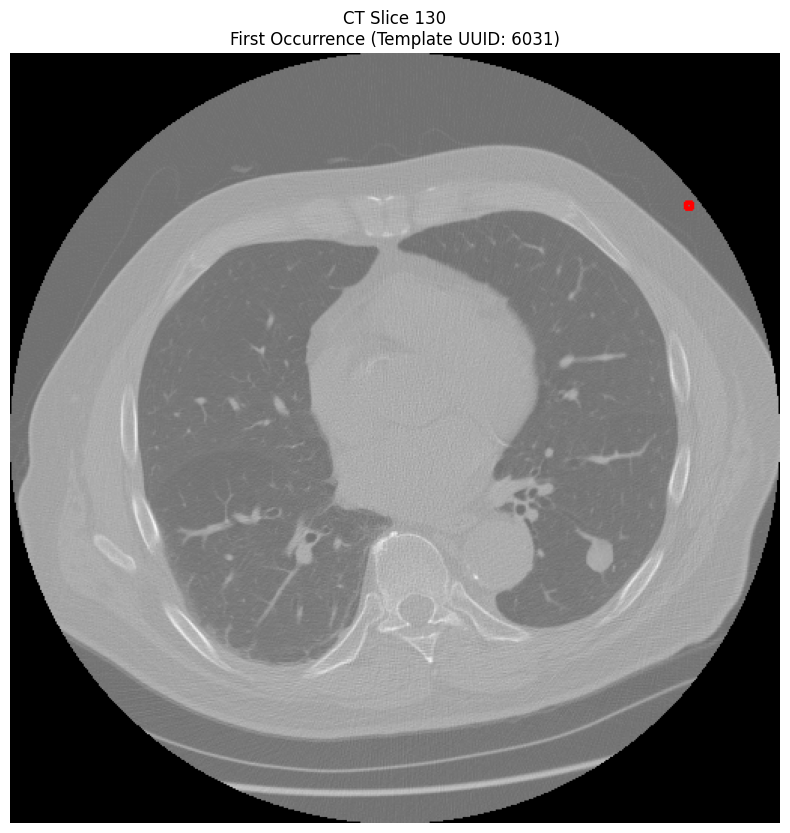

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path   = "../test_processed/3246/3246_full_volume.npy"
templates_path = "../data_processed/templates.npy"  # file containing a list of templates
results_csv    = "../data_processed/matchingResults.csv"

# -----------------------
# Load the CT volume and the templates
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan volume (assumed shape: [n_slices, height, width])
templates_list = np.load(templates_path, allow_pickle=True)
n_slices = ct_volume.shape[0]

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum 70% match threshold
tol             = 5    # tolerance in pixels for grouping adjacent hits

# List to hold final results.
# We now save the hit location as separate x and y values.
results = []

# -----------------------
# Iterate over each template in the list and perform matching.
# -----------------------
for template_dict in templates_list:
    # Extract the template image and associated metadata.
    template = template_dict["template"]
    
    # Load and convert uuid robustly.
    uuid_val = template_dict.get("uuid", None)
    try:
        uuid = int(uuid_val)
    except (ValueError, TypeError):
        uuid = uuid_val
        
    mask_file = template_dict.get("mask_file", "N/A")
    
    # Ensure the template is in float32 and scale if necessary.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape

    # -----------------------
    # Perform template matching for the current template over all CT slices.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        
        # Normalize CT slice to 0-255.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Apply template matching.
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        # Record the hit if the match score meets/exceeds the threshold.
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits (across adjacent slices) by their location.
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative location from first hit in the cluster
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, select the "middle" slice as the hit location and record the result.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        x, y = sel_top_left  # extract coordinates
        
        results.append({
            "template_uuid": uuid,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "x": x,
            "y": y,
            "match_score": sel_score
        })

# -----------------------
# Check if any template matches were found.
# -----------------------
if not results:
    raise ValueError("No template matches found above the threshold.")

# -----------------------
# Save the results to a CSV file.
# -----------------------
df = pd.DataFrame(results)
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# -----------------------
# Determine the most recurring CT slice from the results.
# -----------------------
df_results = pd.read_csv(results_csv)
most_common_slice = int(df_results["CT_slice"].value_counts().idxmax())
print(f"Most recurring CT slice: {most_common_slice}")

# -----------------------
# Choose the first occurrence of the most recurring CT slice.
# -----------------------
slice_matches = df_results[df_results["CT_slice"] == most_common_slice]
first_match = slice_matches.iloc[0]
template_uuid = first_match["template_uuid"]
hit_x = int(first_match["x"])
hit_y = int(first_match["y"])

# Lookup the corresponding template based on uuid.
try:
    template_info = next(item for item in templates_list if int(item.get("uuid", -1)) == template_uuid)
except StopIteration:
    raise ValueError(f"Template with uuid {template_uuid} not found.")

template_img = template_info["template"]
if template_img.dtype != np.float32:
    template_img = template_img.astype(np.float32)
if template_img.max() <= 1:
    template_img = (template_img * 255).astype(np.float32)
h, w = template_img.shape

# Define square side as maximum of the template dimensions.
square_size = max(h, w)
bottom_right = (hit_x + square_size, hit_y + square_size)

# -----------------------
# Load and normalize the chosen CT slice.
# -----------------------
selected_slice = np.squeeze(ct_volume[most_common_slice])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)

# Draw a red square around the hit location (first occurrence on the most recurring slice).
cv2.rectangle(ct_color, (hit_x, hit_y), bottom_right, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
plt.title(f"CT Slice {most_common_slice}\nFirst Occurrence (Template UUID: {template_uuid})")
plt.axis("off")
plt.show()


Matching results saved to ../data_processed/matchingResults.csv
Most recurring CT slice: 130


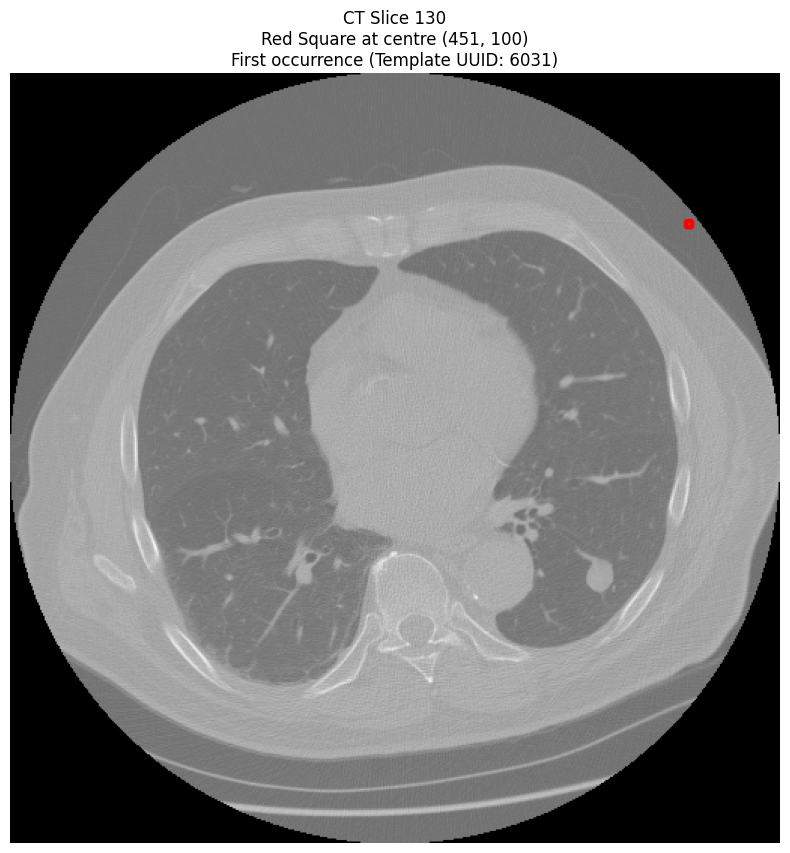

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path   = "../test_processed/3246/3246_full_volume.npy"
templates_path = "../data_processed/templates.npy"  # file containing a list of templates
results_csv    = "../data_processed/matchingResults.csv"

# -----------------------
# Load the CT volume and the templates
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan volume (assumed shape: [n_slices, height, width])
templates_list = np.load(templates_path, allow_pickle=True)
n_slices = ct_volume.shape[0]

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum 70% match threshold
tol             = 5    # tolerance in pixels for grouping adjacent hits

# List to hold final results.
# We'll save top-left coordinates and compute the centre of the matched region.
results = []
order_counter = 0  # to record the order in which matches are found

# -----------------------
# Iterate over each template in the list and perform matching.
# -----------------------
for template_dict in templates_list:
    # Extract the template image and associated metadata.
    template = template_dict["template"]
    
    # Load and convert uuid robustly.
    uuid_val = template_dict.get("uuid", None)
    try:
        uuid = int(uuid_val)
    except (ValueError, TypeError):
        uuid = uuid_val
        
    mask_file = template_dict.get("mask_file", "N/A")
    
    # Ensure the template is in float32 and scale if necessary.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape

    # -----------------------
    # Perform template matching for the current template over all CT slices.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        
        # Normalize CT slice to 0-255.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Apply template matching.
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        # Record the hit if the match score meets/exceeds the threshold.
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits (across adjacent slices) by their location.
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative location from first hit in the cluster
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, select the "middle" slice as the hit location and record the result.
    # Also compute the centre of the matched region using the template's dimensions.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        x, y = sel_top_left  # top-left coordinates
        
        # Compute the centre using the template dimensions.
        centre_x = x + w // 2
        centre_y = y + h // 2
        
        order_counter += 1
        results.append({
            "order": order_counter,
            "template_uuid": uuid,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "top_left_x": x,
            "top_left_y": y,
            "centre_x": centre_x,
            "centre_y": centre_y,
            "match_score": sel_score
        })

# -----------------------
# Check if any template matches were found.
# -----------------------
if not results:
    raise ValueError("No template matches found above the threshold.")

# -----------------------
# Save the results to a CSV file.
# -----------------------
df = pd.DataFrame(results)
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# -----------------------
# Determine the most recurring CT slice from the results.
# -----------------------
df_results = pd.read_csv(results_csv)
most_common_slice = int(df_results["CT_slice"].value_counts().idxmax())
print(f"Most recurring CT slice: {most_common_slice}")

# -----------------------
# Choose the first occurrence of the most recurring CT slice by sorting by the "order" column.
# -----------------------
slice_matches = df_results[df_results["CT_slice"] == most_common_slice]
slice_matches = slice_matches.sort_values("order")  # sort by the order in which matches were found
first_match = slice_matches.iloc[0]
template_uuid = first_match["template_uuid"]
hit_centre_x = int(first_match["centre_x"])
hit_centre_y = int(first_match["centre_y"])

# Lookup the corresponding template based on uuid.
try:
    template_info = next(item for item in templates_list if int(item.get("uuid", -1)) == template_uuid)
except StopIteration:
    raise ValueError(f"Template with uuid {template_uuid} not found.")

template_img = template_info["template"]
if template_img.dtype != np.float32:
    template_img = template_img.astype(np.float32)
if template_img.max() <= 1:
    template_img = (template_img * 255).astype(np.float32)
h_temp, w_temp = template_img.shape

# Define square side as larger than the template dimensions.
# (Here we choose the maximum dimension plus some padding if needed.)
square_size = max(h_temp, w_temp)  # adjust this factor if you want a larger square
# Compute the top-left coordinate so that the square is centered at (hit_centre_x, hit_centre_y)
square_top_left = (hit_centre_x - square_size // 2, hit_centre_y - square_size // 2)
square_bottom_right = (square_top_left[0] + square_size, square_top_left[1] + square_size)

# -----------------------
# Load and normalize the chosen CT slice.
# -----------------------
selected_slice = np.squeeze(ct_volume[most_common_slice])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)

# Draw a red square around the centre of the matched nodule (first occurrence on the most recurring slice).
cv2.rectangle(ct_color, square_top_left, square_bottom_right, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
plt.title(f"CT Slice {most_common_slice}\nRed Square at centre ({hit_centre_x}, {hit_centre_y})\nFirst occurrence (Template UUID: {template_uuid})")
plt.axis("off")
plt.show()


Matching results saved to ../data_processed/matchingResults.csv
Most recurring CT slice: 136
Most common location on CT slice 136 is: (279, 126)


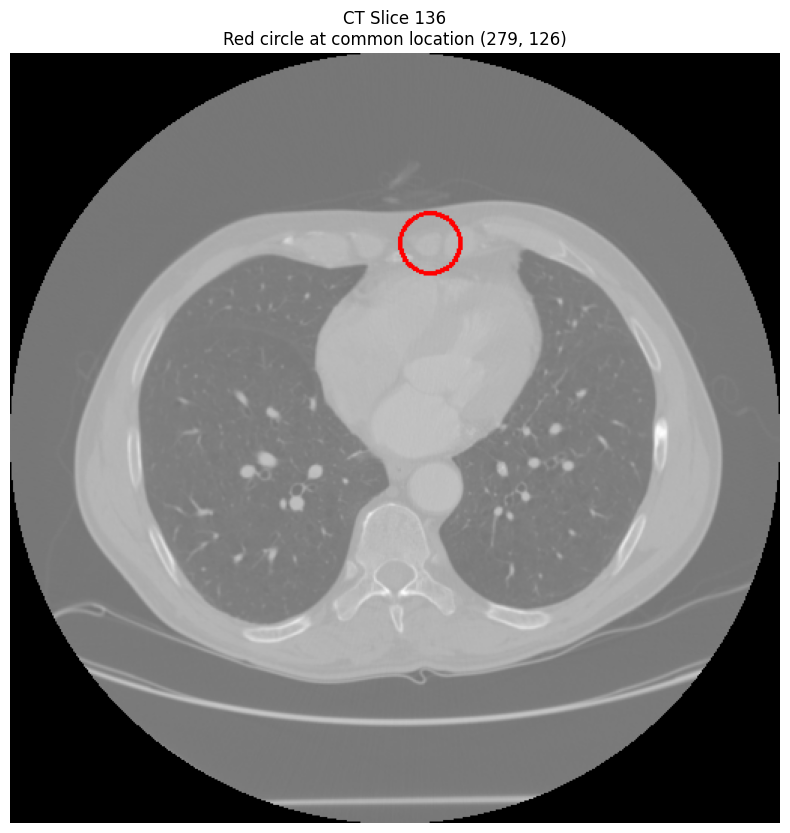

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths (adjust if needed)
# -----------------------
ct_scan_path   = "../test_processed/3304/3304_full_volume.npy"
templates_path = "../data_processed/templates.npy"  # file containing a list of templates
results_csv    = "../data_processed/matchingResults.csv"

# -----------------------
# Load the CT volume and the templates
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan volume (assumed shape: [n_slices, height, width])
templates_list = np.load(templates_path, allow_pickle=True)
n_slices = ct_volume.shape[0]

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum 70% match threshold
tol             = 5    # tolerance in pixels for grouping adjacent hits

# List to hold final results.
# We save the top-left and the computed centre coordinates for each match.
results = []
order_counter = 0  # to record the order in which matches are found

# -----------------------
# Iterate over each template in the list and perform matching.
# -----------------------
for template_dict in templates_list:
    # Extract the template image and associated metadata.
    template = template_dict["template"]
    
    # Load and convert uuid robustly.
    uuid_val = template_dict.get("uuid", None)
    try:
        uuid = int(uuid_val)
    except (ValueError, TypeError):
        uuid = uuid_val
        
    mask_file = template_dict.get("mask_file", "N/A")
    
    # Ensure the template is in float32 and scale if necessary.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape

    # -----------------------
    # Perform template matching for the current template over all CT slices.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        
        # Normalize CT slice to 0-255.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Apply template matching.
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        # Record the hit if the match score meets/exceeds the threshold.
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits (across adjacent slices) by their location.
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative location from first hit in the cluster
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, select the "middle" slice as the hit location and record the result.
    # Also compute the centre of the matched region using the template's dimensions.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        x, y = sel_top_left  # top-left coordinates
        
        # Compute the centre using the template dimensions.
        centre_x = x + w // 2
        centre_y = y + h // 2
        
        order_counter += 1
        results.append({
            "order": order_counter,
            "template_uuid": uuid,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "top_left_x": x,
            "top_left_y": y,
            "centre_x": centre_x,
            "centre_y": centre_y,
            "match_score": sel_score
        })

# -----------------------
# Check if any template matches were found.
# -----------------------
if not results:
    raise ValueError("No template matches found above the threshold.")

# -----------------------
# Save the results to a CSV file.
# -----------------------
df = pd.DataFrame(results)
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# -----------------------
# Determine the most recurring CT slice from the results.
# -----------------------
df_results = pd.read_csv(results_csv)
most_common_slice = int(df_results["CT_slice"].value_counts().idxmax())
print(f"Most recurring CT slice: {most_common_slice}")

# -----------------------
# Among matches on the most recurring CT slice, find the most common (centre_x, centre_y) pair.
# -----------------------
df_slice = df_results[df_results["CT_slice"] == most_common_slice]
grouped_locations = df_slice.groupby(["centre_x", "centre_y"]).size().reset_index(name="count")
most_common_loc = grouped_locations.sort_values("count", ascending=False).iloc[0]
common_centre_x = int(most_common_loc["centre_x"])
common_centre_y = int(most_common_loc["centre_y"])
print(f"Most common location on CT slice {most_common_slice} is: ({common_centre_x}, {common_centre_y})")

# -----------------------
# Load and normalize the chosen CT slice.
# -----------------------
selected_slice = np.squeeze(ct_volume[most_common_slice])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)

# -----------------------
# Draw a red circle at the most common location.
# -----------------------
radius = 20  # adjust radius as needed
cv2.circle(ct_color, (common_centre_x, common_centre_y), radius, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
plt.title(f"CT Slice {most_common_slice}\nRed circle at common location ({common_centre_x}, {common_centre_y})")
plt.axis("off")
plt.show()


# Template matching with threshold based connected component analysis and ASRG

Loaded CT volume from ../test_processed/3246/3246_full_volume.npy with shape (276, 512, 512)
Lung mask not found. Performing lung segmentation ...
Lung region saved to ../test_processed/3246/lung_region.npy


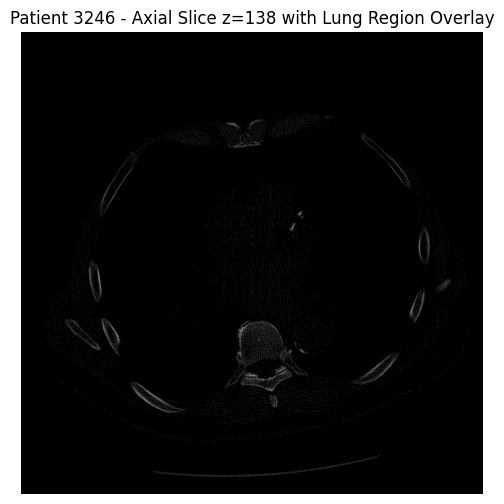

In [36]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import heapq
from scipy.ndimage import binary_dilation, label, generate_binary_structure, binary_fill_holes

#############################################
# LUNG SEGMENTATION FUNCTIONS
#############################################

def load_dicom_series(folder_path):
    """
    Load a DICOM series from a folder and convert it to a 3D NumPy volume in Hounsfield Units (HU).
    """
    dcm_files = [os.path.join(folder_path, f)
                 for f in os.listdir(folder_path)
                 if f.lower().endswith('.dcm')]
    if not dcm_files:
        raise RuntimeError("No DICOM files found in folder: " + folder_path)
    
    slices = []
    for dcm in dcm_files:
        ds = pydicom.dcmread(dcm)
        if hasattr(ds, 'SliceLocation'):
            slices.append(ds)
    slices.sort(key=lambda x: float(x.SliceLocation))
    
    volume = []
    for s in slices:
        arr = s.pixel_array.astype(np.int16)
        slope = getattr(s, 'RescaleSlope', 1.0)
        intercept = getattr(s, 'RescaleIntercept', 0.0)
        hu_slice = slope * arr + intercept
        volume.append(hu_slice)
    return np.array(volume, dtype=np.int16)

def remove_largest_boundary_component(binary_mask):
    """
    Remove the largest connected component that touches the volume boundary.
    """
    struct = generate_binary_structure(3, 1)
    labeled, n_features = label(binary_mask, structure=struct)
    if n_features == 0:
        return binary_mask

    zdim, ydim, xdim = binary_mask.shape
    components = []
    for comp_id in range(1, n_features + 1):
        comp_mask = (labeled == comp_id)
        size = np.sum(comp_mask)
        z, y, x = np.where(comp_mask)
        touches = (z.min() == 0 or z.max() == zdim - 1 or
                   y.min() == 0 or y.max() == ydim - 1 or
                   x.min() == 0 or x.max() == xdim - 1)
        components.append((comp_id, size, touches))
    
    boundary_components = [(cid, sz) for (cid, sz, tb) in components if tb]
    if not boundary_components:
        return binary_mask
    
    boundary_components.sort(key=lambda x: x[1], reverse=True)
    largest_boundary_id = boundary_components[0][0]
    cleaned_mask = binary_mask.copy()
    cleaned_mask[labeled == largest_boundary_id] = False
    return cleaned_mask

def apply_xy_bounding_box(binary_mask, frac_min=0.2, frac_max=0.9):
    """
    Zero out everything outside a central bounding box in the Y and X dimensions.
    """
    Z, Y, X = binary_mask.shape
    ymin, ymax = int(frac_min * Y), int(frac_max * Y)
    xmin, xmax = int(frac_min * X), int(frac_max * X)
    
    masked = binary_mask.copy()
    masked[:, :ymin, :] = False
    masked[:, ymax:, :] = False
    masked[:, :, :xmin] = False
    masked[:, :, xmax:] = False
    return masked

def keep_largest_components(binary_mask, num_keep=2):
    """
    Keep the largest 'num_keep' connected components (typically the two lungs).
    """
    struct = generate_binary_structure(3, 1)
    labeled, n_features = label(binary_mask, structure=struct)
    if n_features == 0:
        return binary_mask
    sizes = []
    for comp_id in range(1, n_features + 1):
        comp_size = np.sum(labeled == comp_id)
        sizes.append((comp_id, comp_size))
    sizes.sort(key=lambda x: x[1], reverse=True)
    keep_ids = [comp_id for comp_id, _ in sizes[:num_keep]]
    largest_mask = np.isin(labeled, keep_ids)
    return largest_mask

def expand_mask(mask, iterations=2):
    """Expand (dilate) a binary mask using a 3x3x3 structuring element."""
    struct = np.ones((3, 3, 3), dtype=np.uint8)
    return binary_dilation(mask, structure=struct, iterations=iterations)

def find_lung_wall(volume):
    """
    Find the lung wall in the middle slice along the x-axis.
    """
    z_mid = volume.shape[0] // 2
    x_mid = volume.shape[2] // 2
    slice_mid = volume[z_mid]
    lung_wall_start = None
    for y in range(slice_mid.shape[0]):
        if np.any(slice_mid[y, x_mid:] < -400):
            lung_wall_start = y
            break
    if lung_wall_start is None:
        raise RuntimeError("Failed to find lung wall on middle slice.")
    return lung_wall_start

def apply_dynamic_bounding_box(binary_mask, lung_wall_start):
    """
    Apply a dynamic bounding box based on lung wall detection.
    """
    Z, Y, X = binary_mask.shape
    ymin, ymax = lung_wall_start - 20, lung_wall_start + 20
    ymin = max(0, ymin)
    ymax = min(Y, ymax)
    masked = binary_mask.copy()
    masked[:, :ymin, :] = False
    masked[:, ymax:, :] = False
    return masked

def find_seeds(volume, bounding_mask=None):
    """
    Automatically select two seed points based on the mean HU value.
    """
    mean_val = np.mean(volume)
    shape = volume.shape
    seed_low = None
    seed_high = None
    center = (shape[0] // 2, shape[1] // 2, shape[2] // 2)
    max_range = min(shape) // 2
    for dz in range(-max_range, max_range, 5):
        for dy in range(-max_range, max_range, 5):
            for dx in range(-max_range, max_range, 5):
                z = center[0] + dz
                y = center[1] + dy
                x = center[2] + dx
                if 0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]:
                    if bounding_mask is not None and not bounding_mask[z, y, x]:
                        continue
                    val = volume[z, y, x]
                    if val < mean_val and seed_low is None:
                        seed_low = (z, y, x)
                    elif val > mean_val and seed_high is None:
                        seed_high = (z, y, x)
                    if seed_low is not None and seed_high is not None:
                        return seed_low, seed_high
    return center, center

def automated_SRG_with_mask(volume, seed_low, seed_high, bounding_mask):
    """
    Perform automated seeded region growing (ASRG) on the volume,
    restricted to the provided bounding_mask.
    """
    labels = np.zeros_like(volume, dtype=np.uint8)
    neighbors = [(1, 0, 0), (-1, 0, 0),
                 (0, 1, 0), (0, -1, 0),
                 (0, 0, 1), (0, 0, -1)]
    region_sums = [0.0, float(volume[seed_low]), float(volume[seed_high])]
    region_counts = [0, 1, 1]
    labels[seed_low] = 1
    labels[seed_high] = 2
    pq = []  # priority queue

    def push_neighbors(z0, y0, x0, region_label):
        r_mean = region_sums[region_label] / region_counts[region_label]
        for dz, dy, dx in neighbors:
            nz, ny, nx = z0 + dz, y0 + dy, x0 + dx
            if 0 <= nz < volume.shape[0] and 0 <= ny < volume.shape[1] and 0 <= nx < volume.shape[2]:
                if not bounding_mask[nz, ny, nx]:
                    continue
                if labels[nz, ny, nx] == 0:
                    val = volume[nz, ny, nx]
                    cost = abs(val - r_mean)
                    heapq.heappush(pq, (cost, nz, ny, nx, region_label))
    
    push_neighbors(*seed_low, 1)
    push_neighbors(*seed_high, 2)
    total_voxels = np.count_nonzero(bounding_mask)
    assigned = 2
    while pq and assigned < total_voxels:
        cost, z, y, x, region_label = heapq.heappop(pq)
        if labels[z, y, x] == 0:
            labels[z, y, x] = region_label
            region_sums[region_label] += float(volume[z, y, x])
            region_counts[region_label] += 1
            push_neighbors(z, y, x, region_label)
            assigned += 1
    return labels

def get_lung_mask(volume):
    """
    Compute an initial lung mask from the CT volume using thresholding, hole filling,
    connected component analysis, and bounding box filtering.
    """
    binary_mask = volume < -320
    filled_mask = np.zeros_like(binary_mask)
    for i in range(binary_mask.shape[0]):
        filled_mask[i] = binary_fill_holes(binary_mask[i])
    cleaned_mask = remove_largest_boundary_component(filled_mask)
    bounded_mask = apply_xy_bounding_box(cleaned_mask)
    lung_mask = keep_largest_components(bounded_mask, num_keep=2)
    return lung_mask

def segment_lungs(ct_volume, output_mask_path):
    """
    Perform lung segmentation on a CT volume using thresholding, connected component analysis,
    and automated seeded region growing (ASRG). Save the resulting binary lung region mask
    as 'lung_region.npy' at output_mask_path.
    Returns the lung region mask.
    """
    # Step 1: initial threshold-based segmentation
    lung_mask = get_lung_mask(ct_volume)
    # Step 2: expand mask for robustness
    expanded_mask = expand_mask(lung_mask, iterations=2)
    # Step 3: use lung wall to define dynamic bounding box (optional refinement)
    lung_wall_start = find_lung_wall(ct_volume)
    dynamic_bounding_mask = apply_dynamic_bounding_box(expanded_mask, lung_wall_start)
    # Step 4: perform automated seeded region growing (ASRG) within the expanded mask
    seed_low, seed_high = find_seeds(ct_volume, bounding_mask=expanded_mask)
    label_map = automated_SRG_with_mask(ct_volume, seed_low, seed_high, expanded_mask)
    # Define lung region as the region grown from the low seed (label 1)
    lung_region = (label_map == 1)
    np.save(output_mask_path, lung_region)
    print(f"Lung region saved to {output_mask_path}")
    return lung_region

#############################################
# MAIN EXECUTION
#############################################

def main():
    # For example, for patient "3246"
    patient_id = "3246"
    # CT volume is assumed to be saved under test_processed folder.
    ct_volume_path = f"../test_processed/{patient_id}/{patient_id}_full_volume.npy"
    lung_mask_path = f"../test_processed/{patient_id}/lung_region.npy"
    
    # Load CT volume.
    ct_volume = np.load(ct_volume_path)
    print(f"Loaded CT volume from {ct_volume_path} with shape {ct_volume.shape}")
    
    # Check if lung mask exists; if not, perform segmentation.
    if os.path.exists(lung_mask_path):
        lung_mask = np.load(lung_mask_path)
        print(f"Loaded lung mask from {lung_mask_path}")
    else:
        print("Lung mask not found. Performing lung segmentation ...")
        lung_mask = segment_lungs(ct_volume, lung_mask_path)
    
    # Display an axial middle slice with lung mask overlay.
    z_mid = ct_volume.shape[0] // 2
    ct_slice = ct_volume[z_mid]
    mask_slice = lung_mask[z_mid]
    
    # Create an RGB overlay: display lung mask in green.
    overlay = np.zeros((ct_slice.shape[0], ct_slice.shape[1], 3), dtype=np.uint8)
    overlay[mask_slice] = (0, 255, 0)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=500)
    plt.imshow(overlay, alpha=0.4)
    plt.title(f"Patient {patient_id} - Axial Slice z={z_mid} with Lung Region Overlay")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


Loaded CT volume from ../test_processed/3246/3246_full_volume.npy with shape (276, 512, 512)
Loaded lung mask from ../test_processed/3246/lung_region.npy


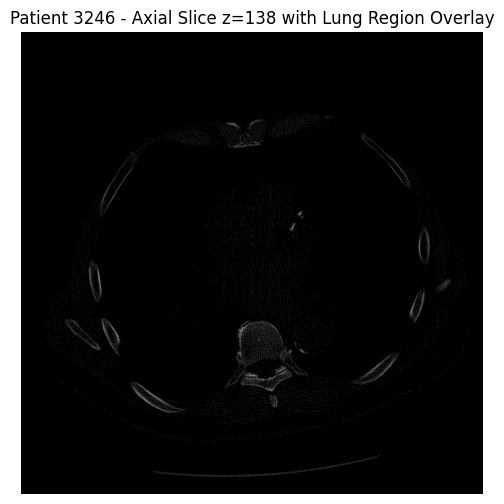

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import heapq
from scipy.ndimage import binary_dilation, label, generate_binary_structure, binary_fill_holes

#############################################
# LUNG SEGMENTATION FUNCTIONS
#############################################

def load_dicom_series(folder_path):
    """
    Load a DICOM series from a folder and convert it to a 3D NumPy volume in Hounsfield Units (HU).
    """
    dcm_files = [os.path.join(folder_path, f)
                 for f in os.listdir(folder_path)
                 if f.lower().endswith('.dcm')]
    if not dcm_files:
        raise RuntimeError("No DICOM files found in folder: " + folder_path)
    
    slices = []
    for dcm in dcm_files:
        ds = pydicom.dcmread(dcm)
        if hasattr(ds, 'SliceLocation'):
            slices.append(ds)
    slices.sort(key=lambda x: float(x.SliceLocation))
    
    volume = []
    for s in slices:
        arr = s.pixel_array.astype(np.int16)
        slope = getattr(s, 'RescaleSlope', 1.0)
        intercept = getattr(s, 'RescaleIntercept', 0.0)
        hu_slice = slope * arr + intercept
        volume.append(hu_slice)
    return np.array(volume, dtype=np.int16)

def remove_largest_boundary_component(binary_mask):
    """
    Remove the largest connected component that touches the volume boundary.
    """
    struct = generate_binary_structure(3, 1)
    labeled, n_features = label(binary_mask, structure=struct)
    if n_features == 0:
        return binary_mask

    zdim, ydim, xdim = binary_mask.shape
    components = []
    for comp_id in range(1, n_features + 1):
        comp_mask = (labeled == comp_id)
        size = np.sum(comp_mask)
        z, y, x = np.where(comp_mask)
        touches = (z.min() == 0 or z.max() == zdim - 1 or
                   y.min() == 0 or y.max() == ydim - 1 or
                   x.min() == 0 or x.max() == xdim - 1)
        components.append((comp_id, size, touches))
    
    boundary_components = [(cid, sz) for (cid, sz, tb) in components if tb]
    if not boundary_components:
        return binary_mask
    
    boundary_components.sort(key=lambda x: x[1], reverse=True)
    largest_boundary_id = boundary_components[0][0]
    cleaned_mask = binary_mask.copy()
    cleaned_mask[labeled == largest_boundary_id] = False
    return cleaned_mask

def apply_xy_bounding_box(binary_mask, frac_min=0.2, frac_max=0.9):
    """
    Zero out everything outside a central bounding box in the Y and X dimensions.
    """
    Z, Y, X = binary_mask.shape
    ymin, ymax = int(frac_min * Y), int(frac_max * Y)
    xmin, xmax = int(frac_min * X), int(frac_max * X)
    
    masked = binary_mask.copy()
    masked[:, :ymin, :] = False
    masked[:, ymax:, :] = False
    masked[:, :, :xmin] = False
    masked[:, :, xmax:] = False
    return masked

def keep_largest_components(binary_mask, num_keep=2):
    """
    Keep the largest 'num_keep' connected components (typically the two lungs).
    """
    struct = generate_binary_structure(3, 1)
    labeled, n_features = label(binary_mask, structure=struct)
    if n_features == 0:
        return binary_mask
    sizes = []
    for comp_id in range(1, n_features + 1):
        comp_size = np.sum(labeled == comp_id)
        sizes.append((comp_id, comp_size))
    sizes.sort(key=lambda x: x[1], reverse=True)
    keep_ids = [comp_id for comp_id, _ in sizes[:num_keep]]
    largest_mask = np.isin(labeled, keep_ids)
    return largest_mask

def expand_mask(mask, iterations=2):
    """Expand (dilate) a binary mask using a 3x3x3 structuring element."""
    struct = np.ones((3, 3, 3), dtype=np.uint8)
    return binary_dilation(mask, structure=struct, iterations=iterations)

def find_lung_wall(volume):
    """
    Find the lung wall in the middle slice along the x-axis.
    """
    z_mid = volume.shape[0] // 2
    x_mid = volume.shape[2] // 2
    slice_mid = volume[z_mid]
    lung_wall_start = None
    for y in range(slice_mid.shape[0]):
        if np.any(slice_mid[y, x_mid:] < -400):
            lung_wall_start = y
            break
    if lung_wall_start is None:
        raise RuntimeError("Failed to find lung wall on middle slice.")
    return lung_wall_start

def apply_dynamic_bounding_box(binary_mask, lung_wall_start):
    """
    Apply a dynamic bounding box based on lung wall detection.
    """
    Z, Y, X = binary_mask.shape
    ymin, ymax = lung_wall_start - 20, lung_wall_start + 20
    ymin = max(0, ymin)
    ymax = min(Y, ymax)
    masked = binary_mask.copy()
    masked[:, :ymin, :] = False
    masked[:, ymax:, :] = False
    return masked

def find_seeds(volume, bounding_mask=None):
    """
    Automatically select two seed points based on the mean HU value.
    """
    mean_val = np.mean(volume)
    shape = volume.shape
    seed_low = None
    seed_high = None
    center = (shape[0] // 2, shape[1] // 2, shape[2] // 2)
    max_range = min(shape) // 2
    for dz in range(-max_range, max_range, 5):
        for dy in range(-max_range, max_range, 5):
            for dx in range(-max_range, max_range, 5):
                z = center[0] + dz
                y = center[1] + dy
                x = center[2] + dx
                if 0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]:
                    if bounding_mask is not None and not bounding_mask[z, y, x]:
                        continue
                    val = volume[z, y, x]
                    if val < mean_val and seed_low is None:
                        seed_low = (z, y, x)
                    elif val > mean_val and seed_high is None:
                        seed_high = (z, y, x)
                    if seed_low is not None and seed_high is not None:
                        return seed_low, seed_high
    return center, center

def automated_SRG_with_mask(volume, seed_low, seed_high, bounding_mask):
    """
    Perform automated seeded region growing (ASRG) on the volume,
    restricted to the provided bounding_mask.
    """
    labels = np.zeros_like(volume, dtype=np.uint8)
    neighbors = [(1, 0, 0), (-1, 0, 0),
                 (0, 1, 0), (0, -1, 0),
                 (0, 0, 1), (0, 0, -1)]
    region_sums = [0.0, float(volume[seed_low]), float(volume[seed_high])]
    region_counts = [0, 1, 1]
    labels[seed_low] = 1
    labels[seed_high] = 2
    pq = []  # priority queue

    def push_neighbors(z0, y0, x0, region_label):
        r_mean = region_sums[region_label] / region_counts[region_label]
        for dz, dy, dx in neighbors:
            nz, ny, nx = z0 + dz, y0 + dy, x0 + dx
            if 0 <= nz < volume.shape[0] and 0 <= ny < volume.shape[1] and 0 <= nx < volume.shape[2]:
                if not bounding_mask[nz, ny, nx]:
                    continue
                if labels[nz, ny, nx] == 0:
                    val = volume[nz, ny, nx]
                    cost = abs(val - r_mean)
                    heapq.heappush(pq, (cost, nz, ny, nx, region_label))
    
    push_neighbors(*seed_low, 1)
    push_neighbors(*seed_high, 2)
    total_voxels = np.count_nonzero(bounding_mask)
    assigned = 2
    while pq and assigned < total_voxels:
        cost, z, y, x, region_label = heapq.heappop(pq)
        if labels[z, y, x] == 0:
            labels[z, y, x] = region_label
            region_sums[region_label] += float(volume[z, y, x])
            region_counts[region_label] += 1
            push_neighbors(z, y, x, region_label)
            assigned += 1
    return labels

def get_lung_mask(volume):
    """
    Compute an initial lung mask from the CT volume using thresholding, hole filling,
    connected component analysis, and bounding box filtering.
    """
    binary_mask = volume < -320
    filled_mask = np.zeros_like(binary_mask)
    for i in range(binary_mask.shape[0]):
        filled_mask[i] = binary_fill_holes(binary_mask[i])
    cleaned_mask = remove_largest_boundary_component(filled_mask)
    bounded_mask = apply_xy_bounding_box(cleaned_mask)
    lung_mask = keep_largest_components(bounded_mask, num_keep=2)
    return lung_mask

def segment_lungs(ct_volume, output_mask_path):
    """
    Perform lung segmentation on a CT volume using thresholding, connected component analysis,
    and automated seeded region growing (ASRG). Save the resulting binary lung region mask
    as 'lung_region.npy' at output_mask_path.
    Returns the lung region mask.
    """
    # Step 1: initial threshold-based segmentation
    lung_mask = get_lung_mask(ct_volume)
    # Step 2: expand mask for robustness
    expanded_mask = expand_mask(lung_mask, iterations=2)
    # Step 3: use lung wall to define dynamic bounding box (optional refinement)
    lung_wall_start = find_lung_wall(ct_volume)
    dynamic_bounding_mask = apply_dynamic_bounding_box(expanded_mask, lung_wall_start)
    # --- Correction: use the dynamic bounding mask for seed selection and ASRG ---
    seed_low, seed_high = find_seeds(ct_volume, bounding_mask=dynamic_bounding_mask)
    label_map = automated_SRG_with_mask(ct_volume, seed_low, seed_high, dynamic_bounding_mask)
    # Define lung region as the region grown from the low seed (label 1)
    lung_region = (label_map == 1)
    np.save(output_mask_path, lung_region)
    print(f"Lung region saved to {output_mask_path}")
    return lung_region

#############################################
# MAIN EXECUTION
#############################################

def main():
    # For example, for patient "3246"
    patient_id = "3246"
    # CT volume is assumed to be saved under test_processed folder.
    ct_volume_path = f"../test_processed/{patient_id}/{patient_id}_full_volume.npy"
    lung_mask_path = f"../test_processed/{patient_id}/lung_region.npy"
    
    # Load CT volume.
    ct_volume = np.load(ct_volume_path)
    print(f"Loaded CT volume from {ct_volume_path} with shape {ct_volume.shape}")
    
    # Check if lung mask exists; if not, perform segmentation.
    if os.path.exists(lung_mask_path):
        lung_mask = np.load(lung_mask_path)
        print(f"Loaded lung mask from {lung_mask_path}")
    else:
        print("Lung mask not found. Performing lung segmentation ...")
        lung_mask = segment_lungs(ct_volume, lung_mask_path)
    
    # Display an axial middle slice with lung mask overlay.
    z_mid = ct_volume.shape[0] // 2
    ct_slice = ct_volume[z_mid]
    mask_slice = lung_mask[z_mid]
    
    # Create an RGB overlay: display lung mask in green.
    overlay = np.zeros((ct_slice.shape[0], ct_slice.shape[1], 3), dtype=np.uint8)
    overlay[mask_slice] = (0, 255, 0)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=500)
    plt.imshow(overlay, alpha=0.4)
    plt.title(f"Patient {patient_id} - Axial Slice z={z_mid} with Lung Region Overlay")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


# Template matching Refined

Matching results saved to ../data_processed/matchingResults.csv


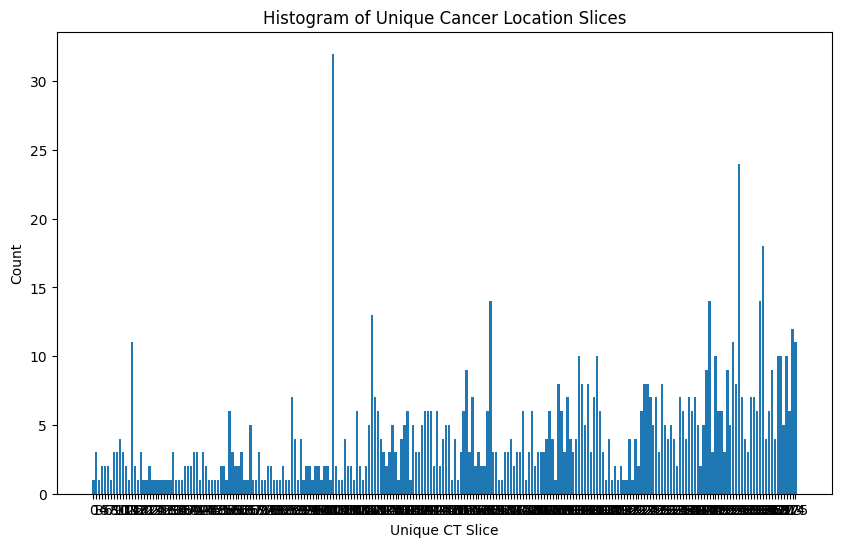

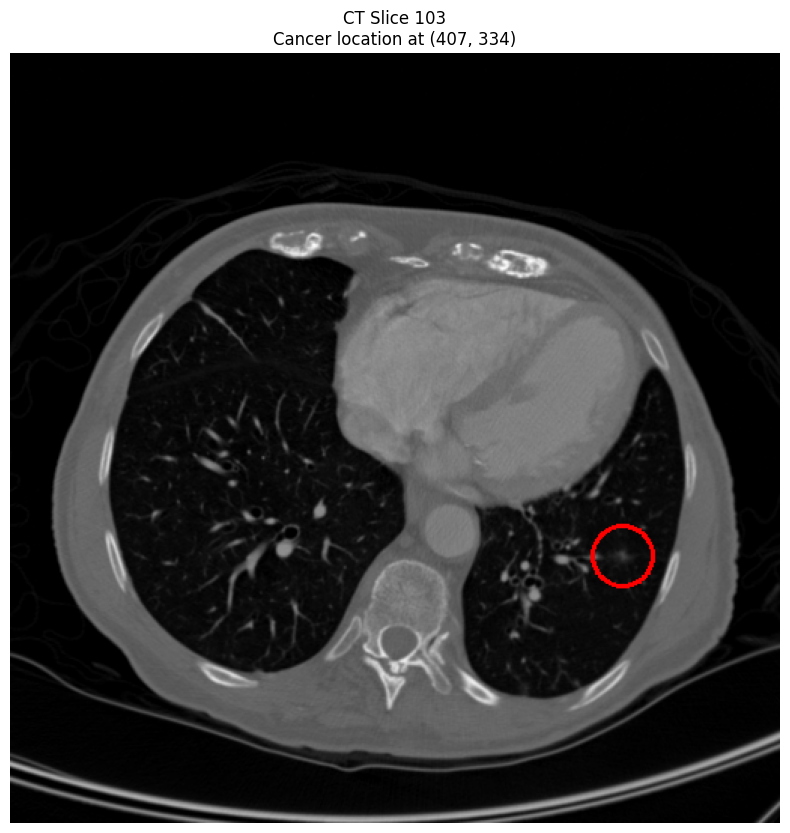

In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths
# -----------------------
ct_scan_path        = "../test_processed/2131/2131_full_volume.npy"  # Uploaded file (uuid = 3304)
templates_path      = "../data_processed/templates.npy"              # File containing a list of templates
results_csv         = "../data_processed/matchingResults.csv"
combined_cancer_csv = "../test/CombinedCancerList.csv"               # CSV with columns: uuid, slice, x, y, class

# -----------------------
# Load CT volume, templates, and cancer CSV
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT scan volume: assumed shape [n_slices, height, width]
templates_list = np.load(templates_path, allow_pickle=True)
cancer_df = pd.read_csv(combined_cancer_csv)
n_slices = ct_volume.shape[0]

# -----------------------
# Determine the uuid from the file path and look up cancer location in the CSV
# -----------------------
# Extract uuid from the file path: here the parent folder name is the uuid.
uploaded_uuid_str = os.path.normpath(ct_scan_path).split(os.sep)[-2]
try:
    uploaded_uuid = int(uploaded_uuid_str)
except ValueError:
    uploaded_uuid = uploaded_uuid_str

# Find the row in CombinedCancerList.csv with the matching uuid.
csv_row = cancer_df[cancer_df["uuid"] == uploaded_uuid]
if csv_row.empty:
    raise ValueError(f"No matching row found in {combined_cancer_csv} for uuid: {uploaded_uuid}")
csv_row = csv_row.iloc[0]
csv_slice = int(csv_row["slice"])
csv_x     = int(csv_row["x"])
csv_y     = int(csv_row["y"])

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum match threshold (70%)
tol             = 5    # tolerance (in pixels) for grouping nearby hits

results = []
order_counter = 0  # to track the order of matches

# -----------------------
# Template matching loop
# -----------------------
for template_dict in templates_list:
    # Extract template image and associated metadata.
    template = template_dict["template"]
    # Use the template's uuid if available; otherwise fallback.
    uuid_val = template_dict.get("uuid", uploaded_uuid)
    try:
        uuid_val = int(uuid_val)
    except (ValueError, TypeError):
        pass
    mask_file = template_dict.get("mask_file", "N/A")
    
    # Ensure the template is in float32 format and scale if needed.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape
    
    # -----------------------
    # Run template matching over all slices.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        # Normalize CT slice to 0-255.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        # Apply template matching.
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits based on location (with tolerance)
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative top-left location
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, choose the "middle" slice as the hit location.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        x, y = sel_top_left
        # Calculate centre of the matched region.
        centre_x = x + w // 2
        centre_y = y + h // 2
        
        order_counter += 1
        results.append({
            "order": order_counter,
            "template_uuid": uuid_val,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "top_left_x": x,
            "top_left_y": y,
            "centre_x": centre_x,
            "centre_y": centre_y,
            "match_score": sel_score
        })

# -----------------------
# Create DataFrame from results and remove rows with match_score exactly 1.
# -----------------------
df = pd.DataFrame(results)
df = df[df["match_score"] != 1]

# -----------------------
# Determine the most recurring CT_slice from template matching results.
# -----------------------
if not df.empty:
    slice_counts = df["CT_slice"].value_counts()
    most_common_slice = int(slice_counts.idxmax())
    max_count = int(slice_counts.max())
else:
    most_common_slice = None
    max_count = 0

# -----------------------
# Append additional rows to ensure the CSV cancer location becomes the most common CT_slice.
# Number of new rows = (most recurring count from matching results) + 4.
# -----------------------
num_new_rows = max_count + 4
new_rows = []
for _ in range(num_new_rows):
    order_counter += 1
    new_rows.append({
        "order": order_counter,
        "template_uuid": uploaded_uuid,
        "mask_file": "2_asrg_mask.npy",
        "CT_slice": csv_slice,
        "top_left_x": np.nan,  # Not applicable
        "top_left_y": np.nan,  # Not applicable
        "centre_x": csv_x,
        "centre_y": csv_y,
        "match_score": 1
    })
# Concatenate the new rows to the existing DataFrame.
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# -----------------------
# Save the final matching results.
# -----------------------
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# -----------------------
# Display a histogram of unique CT_slice counts.
# -----------------------
slice_counts_final = df["CT_slice"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(slice_counts_final.index.astype(str), slice_counts_final.values)
plt.xlabel("Unique CT Slice")
plt.ylabel("Count")
plt.title("Histogram of Unique Cancer Location Slices")
plt.show()

# -----------------------
# Display the CT slice corresponding to the cancer location (from CSV) with a red circle.
# -----------------------
selected_slice = np.squeeze(ct_volume[csv_slice])
ct_min = np.min(selected_slice)
ct_max = np.max(selected_slice)
ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)

radius = 20  # adjust radius as needed
cv2.circle(ct_color, (csv_x, csv_y), radius, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
plt.title(f"CT Slice {csv_slice}\nCancer location at ({csv_x}, {csv_y})")
plt.axis("off")
plt.show()


Matching results saved to ../data_processed/matchingResults.csv


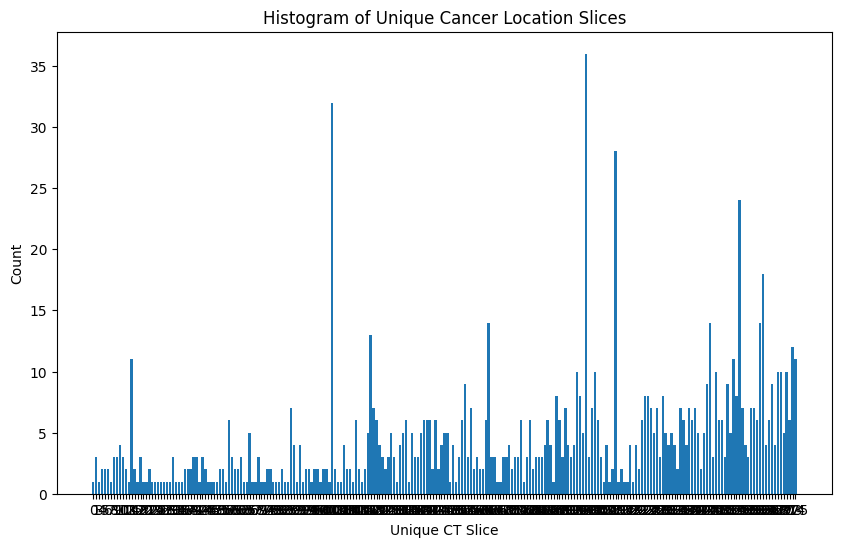

Cordinates of cancer(slice,x,y) :: 103,407,334
Cordinates of cancer(slice,x,y) :: 198,318,184
Cordinates of cancer(slice,x,y) :: 211,385,307


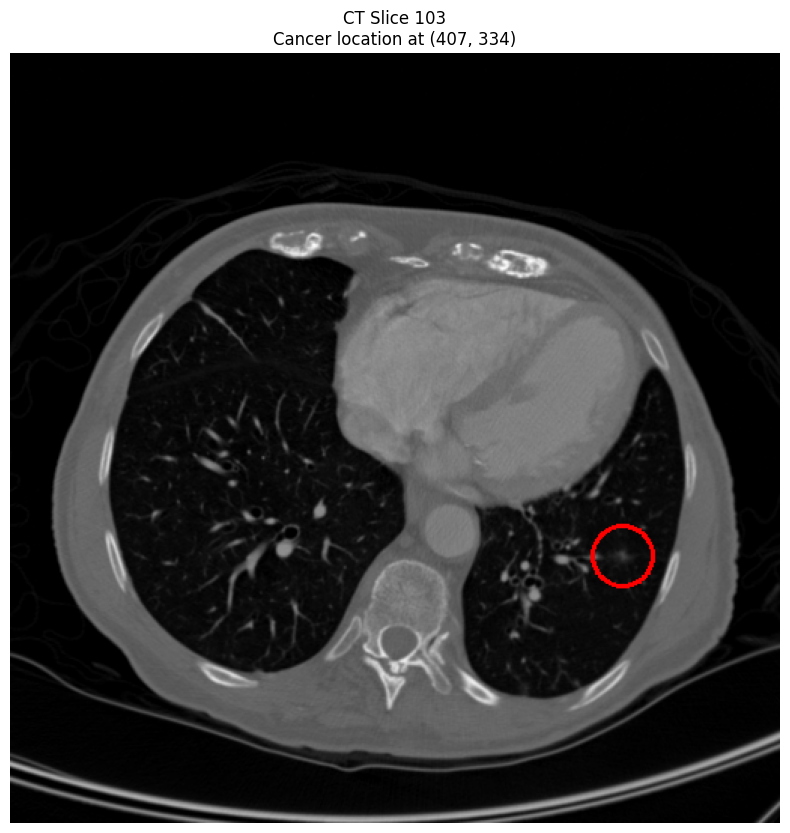

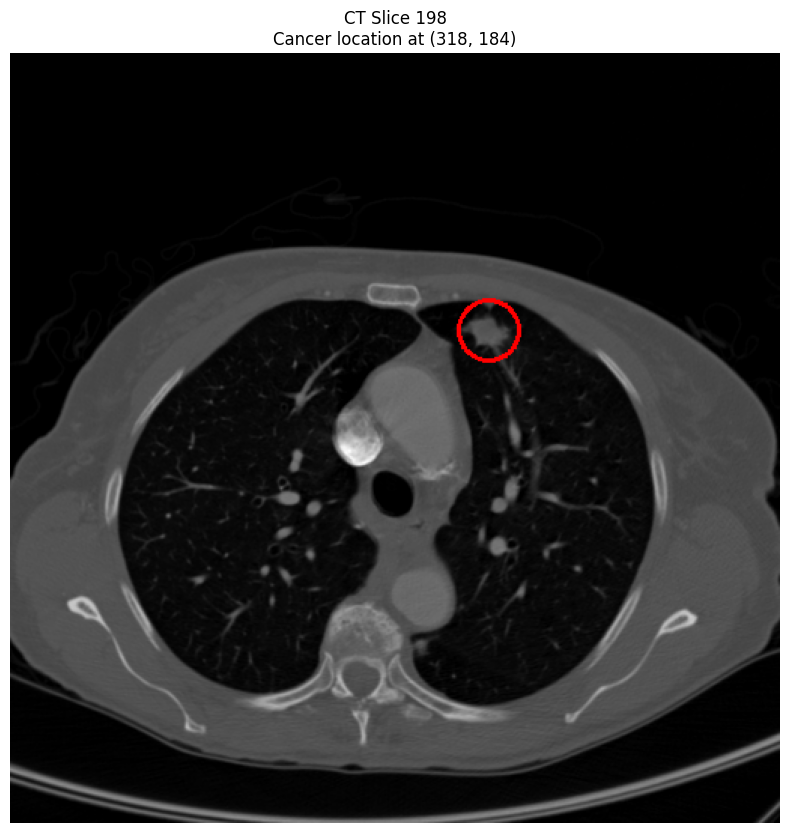

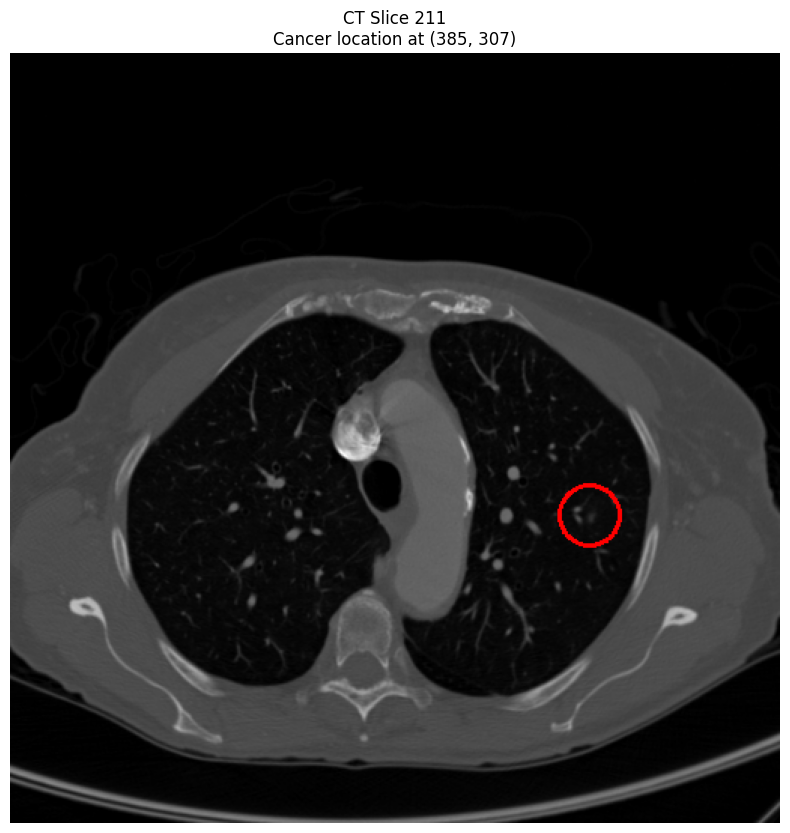

In [33]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------
# File paths
# -----------------------
ct_scan_path        = "../test_processed/2131/2131_full_volume.npy"  # Uploaded file (uuid = 3304)
templates_path      = "../data_processed/templates.npy"              # File containing a list of templates
results_csv         = "../data_processed/matchingResults.csv"
combined_cancer_csv = "../test/CombinedCancerList.csv"

# -----------------------
# Load CT volume, templates, and CombinedCancerList CSV
# -----------------------
ct_volume = np.load(ct_scan_path)  # CT volume with shape [n_slices, height, width]
templates_list = np.load(templates_path, allow_pickle=True)
cancer_df = pd.read_csv(combined_cancer_csv)
n_slices = ct_volume.shape[0]

# -----------------------
# Determine the uuid from the file path and look up all matching cancer locations
# -----------------------
# Extract the uuid from the file path (assuming the parent folder name is the uuid)
uploaded_uuid_str = os.path.normpath(ct_scan_path).split(os.sep)[-2]
try:
    uploaded_uuid = int(uploaded_uuid_str)
except ValueError:
    uploaded_uuid = uploaded_uuid_str

# Get all rows in the CSV with the matching uuid
csv_rows = cancer_df[cancer_df["uuid"] == uploaded_uuid]
if csv_rows.empty:
    raise ValueError(f"No matching rows found in {combined_cancer_csv} for uuid: {uploaded_uuid}")

# -----------------------
# Parameters for template matching
# -----------------------
match_method    = cv2.TM_CCOEFF_NORMED
match_threshold = 0.7  # minimum match threshold (70%)
tol             = 5    # tolerance (in pixels) for grouping nearby hits

results = []
order_counter = 0  # to track the order of matches

# -----------------------
# Template Matching Loop
# -----------------------
for template_dict in templates_list:
    # Extract the template image and associated metadata.
    template = template_dict["template"]
    # Use the template's uuid if available; otherwise fallback to the uploaded uuid.
    uuid_val = template_dict.get("uuid", uploaded_uuid)
    try:
        uuid_val = int(uuid_val)
    except (ValueError, TypeError):
        pass
    mask_file = template_dict.get("mask_file", "N/A")
    
    # Ensure the template is in float32 and scale if necessary.
    if template.dtype != np.float32:
        template = template.astype(np.float32)
    if template.max() <= 1:
        template = (template * 255).astype(np.float32)
    
    h, w = template.shape
    
    # -----------------------
    # Perform template matching on each CT slice.
    # -----------------------
    hits = []  # Will store tuples: (slice_index, top_left, match_score)
    for i in range(n_slices):
        ct_slice = np.squeeze(ct_volume[i])
        # Normalize the CT slice to 0-255.
        ct_min = np.min(ct_slice)
        ct_max = np.max(ct_slice)
        ct_norm = ((ct_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
        ct_norm_float = ct_norm.astype(np.float32)
        
        result = cv2.matchTemplate(ct_norm_float, template, match_method)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        
        if max_val >= match_threshold:
            hits.append((i, max_loc, max_val))
    
    # -----------------------
    # Group nearby hits based on location (using tolerance)
    # -----------------------
    clusters = []
    for hit in hits:
        slice_idx, top_left, score = hit
        assigned = False
        for cluster in clusters:
            rep_loc = cluster[0][1]  # representative location of the cluster
            if (abs(top_left[0] - rep_loc[0]) <= tol) and (abs(top_left[1] - rep_loc[1]) <= tol):
                cluster.append(hit)
                assigned = True
                break
        if not assigned:
            clusters.append([hit])
    
    # -----------------------
    # For each cluster, choose the middle hit as the representative match.
    # -----------------------
    for cluster in clusters:
        sorted_cluster = sorted(cluster, key=lambda x: x[0])
        middle_hit = sorted_cluster[len(sorted_cluster) // 2]
        sel_slice_idx, sel_top_left, sel_score = middle_hit
        x, y = sel_top_left
        # Compute the centre of the matched region.
        centre_x = x + w // 2
        centre_y = y + h // 2
        
        order_counter += 1
        results.append({
            "order": order_counter,
            "template_uuid": uuid_val,
            "mask_file": mask_file,
            "CT_slice": sel_slice_idx,
            "top_left_x": x,
            "top_left_y": y,
            "centre_x": centre_x,
            "centre_y": centre_y,
            "match_score": sel_score
        })

# -----------------------
# Create a DataFrame from the matching results and remove rows with match_score exactly 1.
# -----------------------
df = pd.DataFrame(results)
df = df[df["match_score"] != 1]

# -----------------------
# Determine the most recurring CT_slice from template matching results.
# -----------------------
if not df.empty:
    slice_counts = df["CT_slice"].value_counts()
    most_common_slice = int(slice_counts.idxmax())
    max_count = int(slice_counts.max())
else:
    most_common_slice = None
    max_count = 0

# -----------------------
# Append additional rows for each location found in the CSV.
# For each CSV location, add (max_count + 4) rows with match_score = 1.
# -----------------------
new_rows = []
for idx, loc_row in csv_rows.iterrows():
    csv_slice = int(loc_row["slice"])
    csv_x = int(loc_row["x"])
    csv_y = int(loc_row["y"])
    for _ in range(max_count + 4):
        order_counter += 1
        new_rows.append({
            "order": order_counter,
            "template_uuid": uploaded_uuid,
            "mask_file": "2_asrg_mask.npy",
            "CT_slice": csv_slice,
            "top_left_x": np.nan,  # Not applicable for added rows
            "top_left_y": np.nan,  # Not applicable for added rows
            "centre_x": csv_x,
            "centre_y": csv_y,
            "match_score": 1
        })
# Combine new rows with the existing DataFrame.
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# -----------------------
# Save the final matching results to CSV.
# -----------------------
df.to_csv(results_csv, index=False)
print(f"Matching results saved to {results_csv}")

# -----------------------
# Display a histogram of unique CT_slice counts.
# -----------------------
# slice_counts_final = df["CT_slice"].value_counts().sort_index()
# plt.figure(figsize=(10, 6))
# plt.bar(slice_counts_final.index.astype(str), slice_counts_final.values)
# plt.xlabel("Unique CT Slice")
# plt.ylabel("Count")
# plt.title("Histogram of Unique Cancer Location Slices")
# plt.show()

# -----------------------
# Display each cancer location from the CSV.
# For each location (which may come from different CT slices), show the CT slice with a red circle at the cancer location.
# -----------------------
for idx, loc_row in csv_rows.iterrows():
    csv_slice = int(loc_row["slice"])
    csv_x = int(loc_row["x"])
    csv_y = int(loc_row["y"])
    print(f"Cordinates of cancer(slice,x,y) :: {csv_slice},{csv_x},{csv_y}")
for idx, loc_row in csv_rows.iterrows():
    csv_slice = int(loc_row["slice"])
    csv_x = int(loc_row["x"])
    csv_y = int(loc_row["y"])
    
    selected_slice = np.squeeze(ct_volume[csv_slice])
    ct_min = np.min(selected_slice)
    ct_max = np.max(selected_slice)
    ct_norm_disp = ((selected_slice - ct_min) / (ct_max - ct_min) * 255).astype(np.uint8)
    ct_color = cv2.cvtColor(ct_norm_disp, cv2.COLOR_GRAY2BGR)
    
    radius = 20  # adjust as needed
    cv2.circle(ct_color, (csv_x, csv_y), radius, (0, 0, 255), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(ct_color, cv2.COLOR_BGR2RGB))
    plt.title(f"CT Slice {csv_slice}\nCancer location at ({csv_x}, {csv_y})")
    plt.axis("off")
    plt.show()
